# Большое практическое задание 1
# Классификация изображений цифр метрическими методами

## курс "Машинное обучение 1", программа AIMasters, 2022

## Студент: Файзуллов Айрат Рафагатович

In [ ]:
%load_ext autoreload

%autoreload 2

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline
import pandas as pd

from knn.distances import euclidean_distance, cosine_distance 
from knn.classification import BatchedKNNClassifier
from knn.model_selection import knn_cross_val_score

### 1. Загрузка даннных

Эксперименты этого задания необходимо проводить на датасете MNIST. Загрузить датасет можно при помощи функции `sklearn.datasets.fetch_openml("mnist_784")`

Загружаем датасет mnist

In [ ]:
import sklearn.datasets
data = sklearn.datasets.fetch_openml("mnist_784")

Разибваем датасет на обучающую и тестовую выборку

In [ ]:
Train = data['data'].values[:60000]
Test = data['data'].values[60000:]

### 2. Исследование скорости методов поиска (4 балла)

Исследуйте, какой алгоритм поиска ближайших соседей будет быстрее работать в различных ситуациях.

Измерьте для каждого алгоритма поиска (`kd_tree`, `ball_tree`, `brute` и `my_own`) время нахождения 5 ближайших соседей для каждого объекта тестовой выборки по евклидовой метрике. Выберите подмножество признаков, по которому будет считаться расстояние, размера 10, 20, 100 (подмножество признаков выбирается один раз для всех объектов, случайно).


Подсчитаем время для четырёх алгоритмов нахождения ближайших соседей

In [ ]:
import time

def count_time():   #function for counting time of kneighbours execution
  my_own = []
  brute = []
  ball_tree = []
  kd_tree = []
  for i in (10, 20, 60, 100):
    rand_5 = np.random.choice(784, i, replace=False) 
    rand = np.tile(rand_5, (60000, 1))
    train_short = np.take_along_axis(Train, rand, axis=1)
    rand = np.tile(rand_5, (10000, 1))
    test_short = np.take_along_axis(Test, rand, axis=1)
    class_count_neighbours = BatchedKNNClassifier(nearest_neighbours, algorithm='my_own',
                                              metric='euclidean', weights='uniform',
                                              batch_size=1000)
    class_count_neighbours.fit(train_short)
    start_time = time.time()
    dist, ind = class_count_neighbours.kneighbors(test_short, return_distance=True)
    my_own.append(time.time() - start_time)
    class_count_neighbours = BatchedKNNClassifier(nearest_neighbours, algorithm='brute',
                                              metric='euclidean', weights='uniform',
                                              batch_size=1000)
    class_count_neighbours.fit(train_short)
    start_time = time.time()
    dist, ind = class_count_neighbours.kneighbors(test_short, return_distance=True)
    brute.append(time.time() - start_time)
    class_count_neighbours = BatchedKNNClassifier(nearest_neighbours, algorithm='ball_tree',
                                              metric='euclidean', weights='uniform',
                                              batch_size=1000)
    class_count_neighbours.fit(train_short)
    start_time = time.time()
    dist, ind = class_count_neighbours.kneighbors(test_short, return_distance=True)
    ball_tree.append(time.time() - start_time)
    class_count_neighbours = BatchedKNNClassifier(nearest_neighbours, algorithm='kd_tree',
                                              metric='euclidean', weights='uniform',
                                              batch_size=1000)
    class_count_neighbours.fit(train_short)
    start_time = time.time()
    dist, ind = class_count_neighbours.kneighbors(test_short, return_distance=True)
    kd_tree.append(time.time() - start_time)
  return my_own, brute, ball_tree, kd_tree


nearest_neighbours = 5
class_count_neighbours = BatchedKNNClassifier(nearest_neighbours, algorithm='ball_tree',
                                              metric='euclidean', weights='uniform',
                                              batch_size=1000)
time_my_own, time_brute, time_ball_tree, time_kd_tree = count_time()


Посторим матрицу, составленную из времён затраченных на поиск ближайших соседей при различных алгоритмах

In [ ]:
matrix_time = np.vstack((time_my_own, time_brute, time_ball_tree, time_kd_tree))

Покажем результат в таблице

In [ ]:
import pandas as pd

matrix_new = np.zeros(shape=(16, 2))
matrix_new[:4, 0] = 10
matrix_new[4:8, 0] = 20
matrix_new[8:12, 0] = 60
matrix_new[12:, 0] = 100
matrix_new[:4, 1] = matrix_time[:, 0]
matrix_new[4:8, 1] = matrix_time[:, 1]
matrix_new[8:12, 1] = matrix_time[:, 2]
matrix_new[12:, 1] = matrix_time[:, 3]
lst_alg = ['my own', 'brute', 'ball tree', 'kd tree']*4
df = pd.DataFrame(matrix_new, columns=['Features', 'Time']) 
df['Algorithm'] = lst_alg
df_wide = df.pivot(index='Features', columns='Algorithm', values="Time")
df_wide

Algorithm,ball tree,brute,kd tree,my own
Features,,,,
10.0,6.708775,12.134619,2.325353,23.053449
20.0,28.332890,12.554037,6.197906,24.247158
60.0,130.856560,11.579634,75.062893,22.472139
100.0,225.230137,13.862948,212.380853,24.391083


Покажем результат на графике

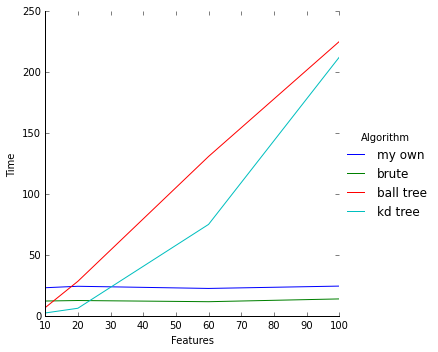

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('classic')
%matplotlib inline

sns.relplot(data=df, x='Features', y='Time', hue='Algorithm', kind="line")

1. Какой алгоритм сработал быстрее всего для каждого из размера подвыборок? Ожидали ли вы такие результаты до проведения эксперимента?



> Для малого кол-ва признаков эффективно работали kd tree и ball tree, когда кол-во признаков стонвится болше, то brute показывает себя как самый эффективный алгоритм.

> Результат был ожидаем: kd tree и ball tree сильно страдают от проклятия размерности, т.к. для использования этих алгоритмов небходимо строить двоичные деревья (для kd tree разбиваем данные по декартовым осям, а при ball tree разбиваем данные на вложенные гиперсферы) и если признаков больше чем 20, то построение дерева уже проблематичено, т.к. разделять пространство большой размерности - трудоёмкий процесс. Но при малых размерностях kd tree и ball tree опережают брутфорс, т.к. дерево строить получается просто и быстро, и поиск по дереву осуществляется тоже очень быстро, в отличии от брутфорса.

>Рассмотрим brute: брутфорс(перебор всех точек) эффективен если у нас малое кол-во образцов для исследования и т.к. в нашей задаче N = 70000, то брутфорс оказывается стабильным. И так же он не сильно зависит от кол-ва признаков

> Рассмотрим my own: в нем был также реализован брутфорс, но он оказался не таким эффективным как brute, но ведет себя по асимптотике как brute



2. Приведите теоретическую сложность каждого из алгоритмов поиска. Согласуется ли время работы алгоритмов на практике с их теоретической вычислительной сложностью? Как вы думаете, почему?


Пусть D - кол-во признаков, а N - кол-во образцов

> Brute:
Сложность при построении - $O(N^2 \cdot D)$, т.к. нам надо подсчитать расстояниее между всеми векторами, и каждый вектор состоит из D элементов, а для подсчета евклидовой нормы необходимо совершить $O(D)$ действий. При запросе на нахождение соседа: $O(N \cdot D)$, т.к. нам уже известны расстояния между векторами

> Kd tree:
Сложность при построении дерева $O(N \cdot Dlog(D))$ - т.к. строили дерево. А для нахождения ближайших соседей через дерево нам необходимо сделать $O(N \cdot D)$ при больших D

>Ball tree:
Сложность при построении дерева $O(N \cdot Dlog(D))$ - т.к. строили дерево. А для нахождения ближайших соседей через дерево нам необходимо сделать $O(N \cdot log(D))$ при больших D

> Заметим, что производительность не согласуется с теорией, это происходит из-за проклятия размерности, т.к. при больших размерностях построение дерева становится неэффективным. У нас малое кол-во точек, и большая размерность, из-за чего тяжело и долго делить пространство большой размерности


3. Какой алгоритм исходя из результатов эксперимента следует использовать в дальнейшем? Выберите алгоритм поиска соседей, который вы будете использовать во всех экспериментах ниже. 



> Т.к. N = 70000 и кол-во признаков равно 784, это нам подсказыват, что лучше использовать brute, т.к. brute будет работать стабильно при таких значениях N. 

> Не будем использовать my own, хоть он и асимптотически работает так же как и brute, т.к. в общем он работает медленнее.

> Не будем использовать kd tree и ball tree, т.к. кол-во признаков у нас очень велико, а эти алгоритмы сильно страдают от проклятия размерности

> Вывод: используем brute в дальнейшем







### 3. Исследование зависимости точности алгоритма на кросс-валидации 


Оцените по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) алгоритма k ближайших соседей в зависимости от следующих факторов:
* количество соседей k от 1 до 10
* используется евклидова или косинусная метрика

Создаем массив меток labels

In [ ]:
from sklearn.model_selection import KFold, BaseCrossValidator
labels = np.array(list(map(int, data['target'].values)))
cv_3 = KFold(n_splits=3)

Кросс-валидация для косинусной метрики 

In [ ]:
dict_accuracy_cos = knn_cross_val_score(X=data['data'].values, y=labels, k_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                                    scoring='accuracy', cv=cv_3,
                                    algorithm='brute',
                                    metric='cosine',
                                    batch_size=1000)

Кросс-валидация для евклидовой метрики 

In [ ]:
dict_accuracy_euclid = knn_cross_val_score(X=data['data'].values, y=labels, k_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                                    scoring='accuracy', cv=cv_3,
                                    algorithm='brute',
                                    metric='euclidean',
                                    batch_size=1000)

Посчитали среднее

In [ ]:
for i in dict_accuracy_cos.keys():
  dict_accuracy_cos[i] = np.mean(dict_accuracy_cos[i])

for i in dict_accuracy_euclid.keys():
  dict_accuracy_euclid[i] = np.mean(dict_accuracy_euclid[i])


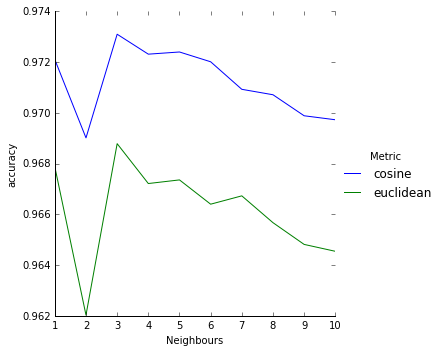

In [ ]:
keys_dict_accuracy_cos = list(dict_accuracy_cos.keys())
values_dict_accuracy_cos = list(dict_accuracy_cos.values())
keys_dict_accuracy_euclid = list(dict_accuracy_euclid.keys())
values_dict_accuracy_euclid = list(dict_accuracy_euclid.values())
name_cos = ['cosine']*10
name_euclid = ['euclidean']*10
df = pd.DataFrame(list(zip(keys_dict_accuracy_cos + keys_dict_accuracy_euclid, 
                           values_dict_accuracy_cos + values_dict_accuracy_euclid,
                           name_cos + name_euclid)), 
                  columns =['Neighbours', 'accuracy', 'Metric'])
sns.relplot(data=df, x='Neighbours', y='accuracy', hue="Metric", kind="line")

1. По результатам эксперимента, какие гиперпараметры вы считаете наиболее оптимальными? Обоснуйте свой выбор (например, если у вас несколько наборов параметров с высоким качеством, обоснуйте как вы выберите среди этих наборов один).

  

> Как видно из графиков: наиболее опитмольно выбирать для кол-ва соседей значение 1 или 3, т.к. на 2 у нас резкое падение вниз, а после 3 можно увидеть как качество плавно ухудшается.

> Если два параметра дают приблизительно одинаково высокое качество, то я выберу тот, который дает более стабильную точность на фолдах.

2. Какая метрика лучше себя показала в экспериментах? Можете ли вы объяснить, почему?

    

> Видно что косинусная метрика показала себя лучше евклидовой метрики. У нас выборка только из 70000 образцов, а признаков довольно много: 784, из-за этого проявляется проклятие размерности, когда нам нужен большой датасет для определения класса вектора. 

> Т.к. при евклидовой метрике мы напрямую считаем расстояние между векторами, а при косинусной метрике мы получаем косинус угла между ними, т.е. с помошью косинусной метрики мы получаем больше информации при большой размерности пространства

   
3. Есть ли на графике зависимости точности от количество соседей "выбросы", резкие падения/повышения качества для одного значения k по сравнению с соседними? Если да, предположите причину появления этих выбросов.

> На графике можно заметить резкие падения и повышения качества при различных значениях k. При больших k, точность начинает постепенно падать, т.к. мы выбираем слишком много ближайших соседей, и у нас могут быть цифры, которые визуально похожи друг на друга, например: 1 и 7 и из-за этого при большом кол-ве ближайших соседей вероятность набрать ошибочно похожих цифр возрастает.

> При 2 у нас резкое падение, это можно объяснить аналогичным образом как было написано выше, только при случае 2ух соседей нам достаточно всего одного соседа, который не будет похож на исследуемый вектор.

> При 3 у нас скачок, т.к. это нечетное кол-во соседей(и вообще можно заметить что при нечтном кол-ве k точность улучшается или не сильно ухудшается), что позваляет более точно узнать какой цифрой явлется наш исселдуемый вектор, и 3 не является очень большим значением, чтобы столкунуться с проблемой как в пункте, который был расписан выше

### 3. Исследование зависимости точности взвешенного алгоритма на кросс-валидации (4 балла)

По результатам предыдущего эксперимента выберите метрику, которую вы будете использовать в этом эксперименте.

Оцените по кросс-валидации с 3 фолдами точность (долю правильно предсказанных ответов) взвешенного алгоритма k ближайших соседей в зависимости от количество соседей k (от 1 до 10).

Голос объекта положите равным `1 / (distance + eps)`, где `eps` = `1e-5`.

Кросс-валидация для косинусной метрики с весами

In [ ]:
dict_accuracy_cos_dist = knn_cross_val_score(X=data['data'].values, y=labels, 
                                            k_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                                            scoring='accuracy', cv=cv_3,
                                            algorithm='brute',
                                            metric='cosine',
                                            weights='distance',
                                            batch_size=1000)

Кросс-валидация для евклидовой метрики с весами

In [ ]:
dict_accuracy_euclid_dist = knn_cross_val_score(X=data['data'].values, y=labels, 
                                                k_list=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
                                                scoring='accuracy', cv=cv_3,
                                                algorithm='brute',
                                                metric='euclidean',
                                                weights='distance')

Посчитаем среднее для весов

In [ ]:
dict_accuracy_cos_dist_mean = {}
dict_accuracy_euclid_dist_mean = {}
for i in dict_accuracy_cos.keys():
  dict_accuracy_cos_dist_mean[i] = np.mean(dict_accuracy_cos_dist[i])

for i in dict_accuracy_euclid.keys():
  dict_accuracy_euclid_dist_mean[i] = np.mean(dict_accuracy_euclid_dist[i])

Покажем результаты точностей на графике

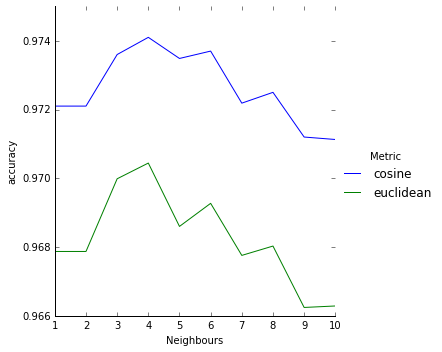

In [ ]:
keys_dict_accuracy_cos = list(dict_accuracy_cos_dist_mean.keys())
values_dict_accuracy_cos = list(dict_accuracy_cos_dist_mean.values())
keys_dict_accuracy_euclid = list(dict_accuracy_euclid_dist_mean.keys())
values_dict_accuracy_euclid = list(dict_accuracy_euclid_dist_mean.values())
name_cos = ['cosine']*10
name_euclid = ['euclidean']*10
df = pd.DataFrame(list(zip(keys_dict_accuracy_cos + keys_dict_accuracy_euclid, 
                           values_dict_accuracy_cos + values_dict_accuracy_euclid,
                           name_cos + name_euclid)), 
                  columns =['Neighbours', 'accuracy', 'Metric'])
sns.relplot(data=df, x='Neighbours', y='accuracy', hue="Metric", kind="line")

1. По результатам эксперимента, какие гиперпараметры вы считаете наиболее оптимальными? Обоснуйте свой выбор.


> По графику видно, что наибольшая точность достигается при k=4. Поэтомы выбор значения 4 будет оптимальным

2. Сравните результаты взвешенного алгоритма с невзвешенным. Объясните разницу/отсутствие разницы в результатах.


> Видно что с помощью взвешенного алгоритма можно добиться большей точности. Это объясняется тем, что мы используем веса, т.е. векторы которые лежат ближе к исследуемому вектору вносят больший вклад в определение класса у исследуемого объекта, что и повышает точность.

> Заметим, что теперь четное значение k дает лучшую точность, в отличие от прошлого эксперимента, т.к. если у нас равное кол-во разных векторов среди ближайших соседей, то мы выберем класс как у тех векторов, которые лежат ближе, что позволяет избегать ошибок как в прошлом опыте и благодаря этому использовать четное k выгоднее. Благодаря этому оптимальный выбор k сдвигается с 3 на 4

### 4. Применение алгоритма и интерпретация ошибок

1. Примените лучший алгоритм к исходной обучающей и тестовой выборке и посчитайте точность классификации. Сравните с точностью по кросс-валидации. Опишите ваши результаты.

Создаем список меток для теструемой и обучающей выборки

In [ ]:
labels_train = labels[:60000]
labels_test = labels[60000:]

Создаем объект класса BatchedKNNClassifier, с помощью которого предскажем метки в тестовой выборке

In [ ]:
optimistic_class = BatchedKNNClassifier(n_neighbors=4, algorithm='brute', weights='distance', 
                                        batch_size=1000, metric='cosine')
optimistic_class.fit(Train, labels_train)

Найдем предсказанные метки

In [ ]:
labels_pred = optimistic_class.predict(Test)

Выведем качество предсказания

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy = ", accuracy_score(labels_test, labels_pred))

accuracy =  0.9752


Можно увидеть, что результат превосходит лучшую точность на кросс-валидации. Это связано с тем, что мы выбрали лучшие аргументы для создания объкта класса BatchedKNNClassifier. И при кросс-валидации выборка делится на обучающую и тестируюмую, обучающая составляет 2/3 всех векторов (около 460000 объектов), а тестируемая 1/3 (около 24000), что сильно отличается от нашего последнего предскзаания, где векторов для обучения было 60000, а тестируемых векторов было 10000, что позволяет добиться лучшего качества. 

2. Постройте и проанализируйте матрицу ошибок (confusion matrix), используйте функцию `sklearn.metrics.confusion_matrix`. Визуализируйте несколько объектов из тестовой выборки, на которых были допущены ошибки. Проанализируйте и укажите их общие черты.

Построили матрицу ошибок

In [148]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(labels_test, labels_pred))

[[ 977    1    0    0    0    0    1    1    0    0]
 [   0 1129    3    1    0    0    2    0    0    0]
 [   8    0 1009    1    1    0    0    8    5    0]
 [   0    1    3  976    1   12    0    4    9    4]
 [   2    1    0    0  946    0    6    2    0   25]
 [   4    0    0    9    1  863    7    1    4    3]
 [   3    3    0    0    1    3  948    0    0    0]
 [   2   10    4    0    1    0    0  998    0   13]
 [   7    1    2    9    3    3    5    4  936    4]
 [   7    7    2    5    7    3    1    4    3  970]]


Видно, что часто путаются цифры 4 и 9, 7 и 9, 3 и 5. Это кажется предсказуемым, т.к. эти цифры и правда визуально схожи

Найдем индексы векторов, которые неверно предсказались

In [207]:
index_test = np.argwhere(labels_test==4)
index_pred = np.argwhere(labels_pred==9)
arr_intersection = np.intersect1d(index_pred.T.ravel(), index_test.T.ravel())

Покажем как выглядит четверка, которая предсказалась как 9

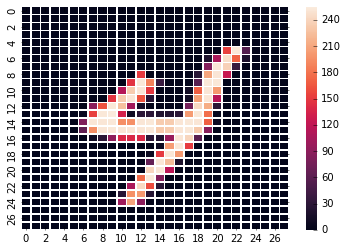

In [201]:
ax = sns.heatmap(np.reshape(data['data'].values[arr_intersection[0]], (28, 28)), linewidth=0.5)
plt.show()

Ещё одна 4 которая предсказалась как 9

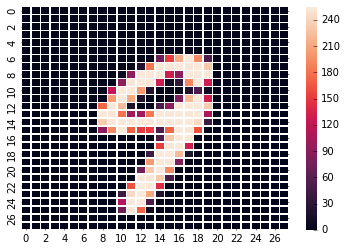

In [209]:
ax = sns.heatmap(np.reshape(data['data'].values[arr_intersection[2]], (28, 28)), linewidth=0.5)
plt.show()

In [ ]:
%%shell
jupyter nbconvert --to html /content/sample_data/KNN_Airat_Faizullov1.ipynb

[NbConvertApp] Converting notebook /content/sample_data/KNN_Airat_Faizullov1.ipynb to html
[NbConvertApp] Writing 421613 bytes to /content/sample_data/KNN_Airat_Faizullov1.html
